In [6]:
!pip install importnb

   ---------------------------------------- 0.0/46.0 kB ? eta -:--:--
   -------------------------- ------------- 30.7/46.0 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 46.0/46.0 kB 760.8 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip install scikit-image

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 16.5 MB/s eta 0:00:01
   --- ------------------------------------ 1.1/12.8 MB 14.2 MB/s eta 0:00:01
   ----- ---------------------------------- 1.8/12.8 MB 13.9 MB/s eta 0:00:01
   ------- -------------------------------- 2.3/12.8 MB 13.6 MB/s eta 0:00:01
   --------- ------------------------------ 2.9/12.8 MB 13.4 MB/s eta 0:00:01
   ----------- ---------------------------- 3.6/12.8 MB 13.3 MB/s eta 0:00:01
   ------------ --------------------------- 4.1/12.8 MB 13.2 MB/s eta 0:00:01
   -------------- ------------------------- 4.8/12.8 MB 13.2 MB/s eta 0:00:01
   ---------------- ----------------------- 5.4/12.8 MB 13.2 MB/s eta 0:00


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
import numpy as np
import os  # Import os
from importnb import Notebook
import config  # Import your configuration
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader, Subset, random_split # If not already imported
import pandas as pd # If not already imported
from tqdm.auto import tqdm

with Notebook():
    from action_conditioned_diffusion_world_model_gemini import SimpleUNet, forward_diffusion_sample, linear_beta_schedule, cosine_beta_schedule  # Import necessary functions
    from jetbot_dataset import *

In [2]:
def evaluate_model_quantitative(model, test_dataloader, betas, alphas_cumprod, num_timesteps, device, num_prev_frames, action_tolerance=1e-6):
    """
    Evaluates the model's single-step prediction accuracy using MSE and SSIM,
    correctly handling Subset objects.

    Args:
        model: The trained diffusion model (U-Net).
        test_dataloader: DataLoader for the test set (can wrap Subset).
        betas: Beta values for the diffusion schedule.
        alphas_cumprod: Cumulative product of alphas.
        num_timesteps: Total number of diffusion timesteps.
        device: Device (CPU or GPU).
        num_prev_frames: Number of previous frames used by the model.
        action_tolerance: Tolerance for comparing floating point action values.

    Returns:
        A dictionary containing average metrics (overall and per action).
    """
    model.eval()
    metrics = {
        'overall': {'mse': [], 'ssim': []},
        0.0: {'mse': [], 'ssim': []},
    }

    # --- Get the underlying original JetbotDataset and the indices used by the test_dataloader ---
    subset_dataset = test_dataloader.dataset # This is the direct dataset object from the loader
    original_jetbot_dataset = subset_dataset
    dataloader_indices = list(range(len(subset_dataset))) # Indices 0..N-1 relative to subset_dataset

    # Drill down to find the original dataset if subset_dataset is a Subset
    active_indices = list(range(len(original_jetbot_dataset))) # Start with indices of the current layer
    while isinstance(original_jetbot_dataset, Subset):
        # Map current indices to the parent dataset's indices
        active_indices = [original_jetbot_dataset.indices[i] for i in active_indices]
        original_jetbot_dataset = original_jetbot_dataset.dataset # Go to parent

    # Now, original_jetbot_dataset is the actual JetbotDataset instance
    # and active_indices contains the indices from the original JetbotDataset
    # that are actually used by the test_dataloader (after potential nested Subsets)

    full_dataset_df = original_jetbot_dataset.dataframe # Access dataframe safely

    # Find unique actions within the *active* subset for reporting
    # Map active_indices back to the valid_indices list of the original dataset
    original_valid_indices = original_jetbot_dataset.valid_indices
    actual_df_indices_in_subset = [original_valid_indices[i] for i in active_indices]

    test_actions = full_dataset_df.iloc[actual_df_indices_in_subset]['action'].unique()
    non_zero_actions = [a for a in test_actions if abs(a) > action_tolerance]
    for a in non_zero_actions:
        metrics[a] = {'mse': [], 'ssim': []}
    # --- End Setup ---

    print(f"Starting quantitative evaluation on {len(subset_dataset)} test samples...")

    with torch.no_grad():
        # We iterate using the dataloader, which handles batching (size 1) and indices
        for i, (current_frame_tensor, action_tensor, prev_frames_tensor) in \
                enumerate(tqdm(test_dataloader, desc="Evaluating Test Set")):

            # Data is already loaded and potentially transformed by DataLoader/Dataset
            current_frame_tensor = current_frame_tensor.to(device) # (1, C, H, W)
            action_tensor = action_tensor.to(device)        # (1, 1)
            prev_frames_tensor = prev_frames_tensor.to(device)    # (1, N*C, H, W)

            action_value = action_tensor.item() # Scalar action

            # --- Predict the next frame ---
            t_sample = torch.tensor([num_timesteps - 1], device=device, dtype=torch.long)
            # Use current_frame_tensor directly (it's the output of __getitem__)
            x_noisy, _ = forward_diffusion_sample(current_frame_tensor, t_sample, betas, alphas_cumprod, device)
            x = x_noisy

            for t_val in reversed(range(1, num_timesteps)):
                t = (torch.ones(1) * t_val).long().to(device)
                with torch.cuda.amp.autocast(enabled=config.USE_FP16):
                    predicted_noise = model(x, t, action_tensor, prev_frames_tensor)

                # Ensure alpha, beta, etc. are accessible (defined globally or passed)
                alpha = alphas[t][:, None, None, None]
                alpha_hat = alphas_cumprod[t][:, None, None, None]
                beta = betas[t][:, None, None, None]

                if t_val > 1: noise = torch.randn_like(x)
                else: noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

            predicted_next_frame_tensor = x # Range [-1, 1]

            # --- Get the Ground Truth Next Frame ---
            ground_truth_next_frame_tensor = None
            # Get the index *within the current subset* for the current item `i`
            current_subset_index = i
            # Find the corresponding index in the original JetbotDataset's valid_indices list
            current_original_valid_index_position = active_indices[current_subset_index]
            current_actual_df_index = original_jetbot_dataset.valid_indices[current_original_valid_index_position]

            # Find the *next* sequential index in the *original* valid_indices list
            next_original_valid_index_position = -1
            for j in range(len(original_jetbot_dataset.valid_indices)):
                 if original_jetbot_dataset.valid_indices[j] == current_actual_df_index:
                      if j + 1 < len(original_jetbot_dataset.valid_indices):
                           next_original_valid_index_position = j + 1
                      break

            if next_original_valid_index_position != -1:
                 next_actual_df_index = original_jetbot_dataset.valid_indices[next_original_valid_index_position]
                 # Check if the next frame belongs to the SAME session
                 current_session_id = full_dataset_df.iloc[current_actual_df_index]['session_id']
                 next_session_id = full_dataset_df.iloc[next_actual_df_index]['session_id']

                 # Check if they were originally consecutive in the dataframe
                 if current_session_id == next_session_id and next_actual_df_index == current_actual_df_index + 1:
                    # Fetch the ground truth using the original dataset's __getitem__
                    # We need the index relative to the start of valid_indices list
                    ground_truth_next_frame_tensor, _, _ = original_jetbot_dataset[next_original_valid_index_position] # Use the index *within* valid_indices
                    ground_truth_next_frame_tensor = ground_truth_next_frame_tensor.unsqueeze(0).to(device)


            # --- Calculate Metrics (if ground truth is available) ---
            if ground_truth_next_frame_tensor is not None:
                # MSE
                mse = F.mse_loss(predicted_next_frame_tensor, ground_truth_next_frame_tensor).item()

                # SSIM
                pred_unnorm = (predicted_next_frame_tensor.clamp(-1, 1).squeeze(0).cpu().numpy() + 1) / 2
                gt_unnorm = (ground_truth_next_frame_tensor.clamp(-1, 1).squeeze(0).cpu().numpy() + 1) / 2
                pred_unnorm = np.transpose(pred_unnorm, (1, 2, 0))
                gt_unnorm = np.transpose(gt_unnorm, (1, 2, 0))
                try: # Add try-except for SSIM calculation issues
                    ssim_val = ssim(gt_unnorm, pred_unnorm, data_range=1.0, channel_axis=-1, win_size=7) # Use channel_axis for skimage >= 0.19
                except ValueError as e:
                    print(f"Warning: SSIM calculation failed for sample {i}. Error: {e}. Skipping SSIM for this sample.")
                    ssim_val = np.nan # Assign NaN if calculation fails

                # Store metrics if SSIM was successful
                if not np.isnan(ssim_val):
                    metrics['overall']['mse'].append(mse)
                    metrics['overall']['ssim'].append(ssim_val)

                    action_key = 0.0 if abs(action_value) < action_tolerance else action_value
                    # Find closest matching key if not exact match (for float issues)
                    closest_key = action_key
                    if action_key not in metrics:
                         found_key = False
                         for k in metrics.keys():
                              if isinstance(k, float) and abs(action_key - k) < action_tolerance:
                                   closest_key = k
                                   found_key = True
                                   break
                         if not found_key: # If truly unknown action, add it
                              metrics[action_key] = {'mse': [], 'ssim': []}

                    metrics[closest_key]['mse'].append(mse)
                    metrics[closest_key]['ssim'].append(ssim_val)

            # --- End Metric Calculation ---

    # --- Calculate Averages ---
    avg_metrics = {'overall': {}, **{a: {} for a in metrics if a != 'overall'}}
    for action_key, results in metrics.items():
        if results['mse']: # Check if list is not empty
            avg_metrics[action_key]['avg_mse'] = np.nanmean(results['mse']) # Use nanmean
            avg_metrics[action_key]['avg_ssim'] = np.nanmean(results['ssim']) # Use nanmean
            avg_metrics[action_key]['count'] = len(results['mse']) # Count successful calculations
        else:
            avg_metrics[action_key]['avg_mse'] = float('nan')
            avg_metrics[action_key]['avg_ssim'] = float('nan')
            avg_metrics[action_key]['count'] = 0

    # --- Print Results ---
    print("\n--- Quantitative Evaluation Results ---")
    for action_key, results in avg_metrics.items():
         if results['count'] > 0:
              print(f"Action: {action_key} (Count: {results['count']})")
              print(f"  Avg MSE:  {results['avg_mse']:.6f}")
              print(f"  Avg SSIM: {results['avg_ssim']:.4f}")
         else:
              print(f"Action: {action_key} (Count: 0) - No valid data found for evaluation.")
    print("------------------------------------")

    return avg_metrics

In [3]:
# --- Helper Function for Displaying PIL Images in Subplots ---
def display_frame_pil(pil_frame, ax, title=None):
    """Displays a PIL Image on a matplotlib Axes object."""
    ax.imshow(pil_frame)
    ax.axis('off')
    if title:
        ax.set_title(title)

def test_multistep_prediction(
    model,
    initial_current_tensor,   # Starting frame as preprocessed Tensor
    initial_prev_frames_tensor,# Actual previous frames as preprocessed Tensor
    actions,                  # Tensor of actions for future steps
    betas,
    alphas_cumprod,
    num_timesteps,
    device,
    num_prev_frames,
    image_size,
    output_dir,
    display=True
):
    """
    Tests multi-step prediction using actual initial previous frames.
    Initial PIL image for display is generated internally.

    Args:
        model: Trained diffusion model (U-Net).
        initial_current_tensor: Starting frame (image_t) as preprocessed Tensor (shape [1, C, H, W]).
        initial_prev_frames_tensor: Stack of actual previous frames (image_{t-N+1} to image_{t-1})
                                     as preprocessed Tensor (shape [1, N*C, H, W]).
        actions: Tensor of actions (shape: (n, 1)) for steps t, t+1, ..., t+n-1.
        (Other arguments remain the same)
        display: Whether to display the plot using matplotlib.

    Returns:
        A list of PIL Images representing the predicted frames (step t+1 onwards).
    """

    model.eval()
    num_steps = actions.shape[0]
    predicted_frames = [] # Will store PIL Images

    # --- Use the provided initial tensors ---
    current_frame_tensor = initial_current_tensor.to(device) # Ensure it's on device
    prev_frames_tensor = initial_prev_frames_tensor.to(device) # Ensure it's on device

    # --- Create initial PIL image for display later ---
    initial_frame_pil = transforms.ToPILImage()(((initial_current_tensor[0].clamp(-1, 1) + 1) / 2 * 255).type(torch.uint8)).convert("RGB")

    start_time = time.time()

    with torch.no_grad():
        for step in range(num_steps):
            action = actions[step].unsqueeze(0).to(device) # Action for the current step

            # --- Predict frame step+1 based on frame step ---
            t_sample = torch.tensor([num_timesteps - 1], device=device, dtype=torch.long)
            x_noisy, _ = forward_diffusion_sample(current_frame_tensor, t_sample, betas, alphas_cumprod, device)
            x = x_noisy

            for i in reversed(range(1, num_timesteps)):
                t = (torch.ones(1) * i).long().to(device)
                with torch.cuda.amp.autocast(enabled=config.USE_FP16):
                    # Pass the *rolling* previous frames tensor here
                    predicted_noise = model(x, t, action, prev_frames_tensor) # Use the updated prev_frames_tensor

                # (Denoising formula remains the same)
                alpha = alphas[t][:, None, None, None]
                alpha_hat = alphas_cumprod[t][:, None, None, None]
                beta = betas[t][:, None, None, None]
                if i > 1: noise = torch.randn_like(x)
                else: noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            # --- End Denoising loop ---

            # Predicted frame for this step (t+1, t+2 etc.)
            predicted_frame_tensor = x # Range [-1, 1]

            # --- Post-process for storage/display ---
            predicted_frame_tensor_unnorm = (predicted_frame_tensor.clamp(-1, 1) + 1) / 2
            predicted_frame_tensor_uint8 = (predicted_frame_tensor_unnorm * 255).type(torch.uint8)
            predicted_frame_pil = transforms.ToPILImage()(predicted_frame_tensor_uint8[0].cpu()).convert("RGB")
            predicted_frames.append(predicted_frame_pil)

            # --- Update State for the *Next* Prediction Step ---
            current_frame_tensor = predicted_frame_tensor # Use the predicted tensor directly
            # Update the rolling history buffer
            prev_frames_tensor = torch.cat([prev_frames_tensor[:, 3:, :, :], current_frame_tensor], dim=1)


    end_time = time.time()
    total_time = end_time - start_time
    print(f"Generated {num_steps} frames in {total_time:.4f} seconds")
    print(f"Average time per frame: {total_time / num_steps:.4f} seconds")

    # --- Display using Matplotlib ---
    if display:
        num_cols = num_steps + 1 # Initial frame + N predicted steps
        fig, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 5.5))

        display_frame_pil(initial_frame_pil, axes[0], title="Initial Frame (t)") # Use internally generated PIL

        for i, frame in enumerate(predicted_frames):
            display_frame_pil(frame, axes[i + 1], title=f"Pred Frame (t+{i+1})\nAction: {actions[i].item():.2f}")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return predicted_frames

def filter_dataset_by_action(input_dataset, target_actions, tolerance=1e-6):
    """
    Creates a Subset of a dataset containing only samples with specific actions.

    Args:
        input_dataset (torch.utils.data.Dataset): The dataset or subset to filter
            (e.g., your train_dataset or test_dataset). It assumes the dataset's
            __getitem__ returns (image, action_tensor, prev_frames).
        target_actions (float or list/tuple of float): The action value(s) to keep.
        tolerance (float): Tolerance for floating-point comparison of actions.

    Returns:
        torch.utils.data.Subset: A new subset containing only the samples
                                 with the target action(s). Returns an empty
                                 Subset if no matching samples are found.
    """
    if not isinstance(target_actions, (list, tuple)):
        target_actions = [target_actions] # Ensure it's a list

    print(f"Filtering dataset with {len(input_dataset)} samples for actions: {target_actions}")
    filtered_indices = []
    for i in tqdm(range(len(input_dataset)), desc="Filtering Dataset"):
        try:
            # Access the data point to get the action
            # __getitem__ returns: image, action_tensor, prev_frames
            _, action_tensor, _ = input_dataset[i]
            action_value = action_tensor.item() # Get scalar value

            # Check if the action matches any of the target actions within tolerance
            for target in target_actions:
                if abs(action_value - target) < tolerance:
                    filtered_indices.append(i)
                    break # No need to check other targets for this index
        except Exception as e:
            print(f"Warning: Error processing index {i} during filtering: {e}")
            # Decide whether to skip or raise, depending on expected data integrity
            continue

    if not filtered_indices:
        print(f"Warning: No samples found matching actions {target_actions}.")

    print(f"Filtered down to {len(filtered_indices)} samples.")
    return Subset(input_dataset, filtered_indices)

In [6]:
model = SimpleUNet(num_prev_frames=config.NUM_PREV_FRAMES).to(config.DEVICE)
checkpoint_path = config.LOAD_CHECKPOINT# os.path.join(config.CHECKPOINT_DIR, 'model_best_epoch_116.pth')  # Example path. Use the *actual* path.
checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load diffusion parameters (MUST BE THE SAME AS TRAINING)
if config.SCHEDULE_TYPE == 'linear':
    betas = linear_beta_schedule(config.NUM_TIMESTEPS, config.BETA_START, config.BETA_END).to(config.DEVICE)
elif config.SCHEDULE_TYPE == 'cosine':
    betas = cosine_beta_schedule(config.NUM_TIMESTEPS).to(config.DEVICE)
else:
    raise ValueError(f"Invalid SCHEDULE_TYPE: {config.SCHEDULE_TYPE}")

alphas = (1. - betas).to(config.DEVICE)
alphas_cumprod = torch.cumprod(alphas, axis=0).to(config.DEVICE)

# --- Create Dataset and DataLoader ---
dataset = JetbotDataset(config.CSV_PATH, config.DATA_DIR, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=config.TRANSFORM)


Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037


In [5]:
config.LOAD_CHECKPOINT

'output_two_action_model_v2_test\\checkpoints\\model_best_epoch_116.pth'

In [35]:
target_action = .1
dataset_action_0_1 = filter_dataset_by_action(dataset, target_action)

Filtering dataset with 23037 samples for actions: [0.1]


Filtering Dataset:   0%|          | 0/23037 [00:00<?, ?it/s]

Filtered down to 10814 samples.


In [31]:
train_dataset, test_dataset = load_train_test_split(dataset, config.SPLIT_DATASET_FILENAME)
test_dataset = Subset(test_dataset, range(10))

if test_dataset is None:
     print("Error: Could not load or create test dataset split. Exiting.")
     exit()
else:
     print(f"Using test dataset split with {len(test_dataset)} samples.")

# --- Create Test DataLoader ---
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

# --- Run Quantitative Evaluation ---
evaluation_results = evaluate_model_quantitative(
    model, test_dataloader, betas, alphas_cumprod,
    config.NUM_TIMESTEPS, config.DEVICE, config.NUM_PREV_FRAMES
)

# --- Optional: Run Qualitative Multi-step Prediction (from before) ---
print("\n--- Running Qualitative Multi-step Prediction ---")
try:
    # Load a random frame for visualization
    random_idx_for_vis = random.randint(0, len(test_dataset) - 1)
    vis_image, vis_action, vis_prev_frames = test_dataset[random_idx_for_vis]
    initial_frame_pil = transforms.ToPILImage()(((vis_image.clamp(-1, 1) + 1) / 2 * 255).type(torch.uint8)).convert("RGB")

    # Create a sequence of actions for visualization
    num_vis_steps = 4
    vis_actions = torch.tensor([[0.1]] * num_vis_steps, dtype=torch.float32) # Example: constant 0.1

    predicted_vis_frames = test_multistep_prediction(
        model, initial_frame_pil, vis_actions, betas, alphas_cumprod,
        config.NUM_TIMESTEPS, config.DEVICE, config.NUM_PREV_FRAMES, config.IMAGE_SIZE,
        config.OUTPUT_DIR,
        display=True # Show the plot
    )
except Exception as e:
    print(f"Error during qualitative visualization: {e}")

print("Evaluation Script Finished.")


Using test dataset split with 10 samples.
Starting quantitative evaluation on 10 test samples...


Evaluating Test Set:   0%|          | 0/10 [00:00<?, ?it/s]


--- Quantitative Evaluation Results ---
Action: overall (Count: 9)
  Avg MSE:  0.002373
  Avg SSIM: 0.8237
Action: 0.0 (Count: 7)
  Avg MSE:  0.002007
  Avg SSIM: 0.8381
Action: 0.1 (Count: 2)
  Avg MSE:  0.003653
  Avg SSIM: 0.7730
------------------------------------

--- Running Qualitative Multi-step Prediction ---
Error during qualitative visualization: name 'random' is not defined
Evaluation Script Finished.


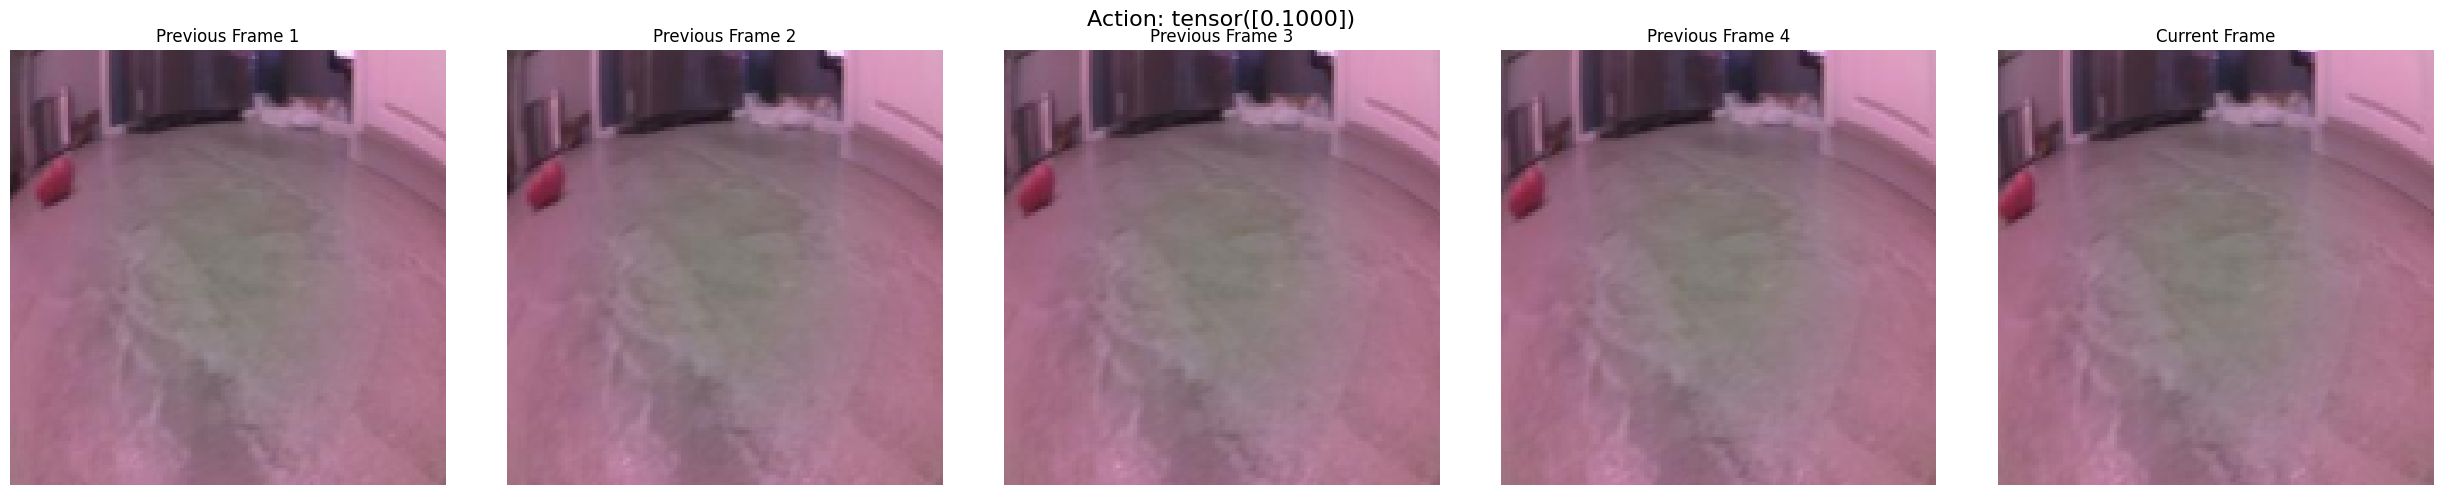

Generated 4 frames in 28.4750 seconds
Average time per frame: 7.1187 seconds


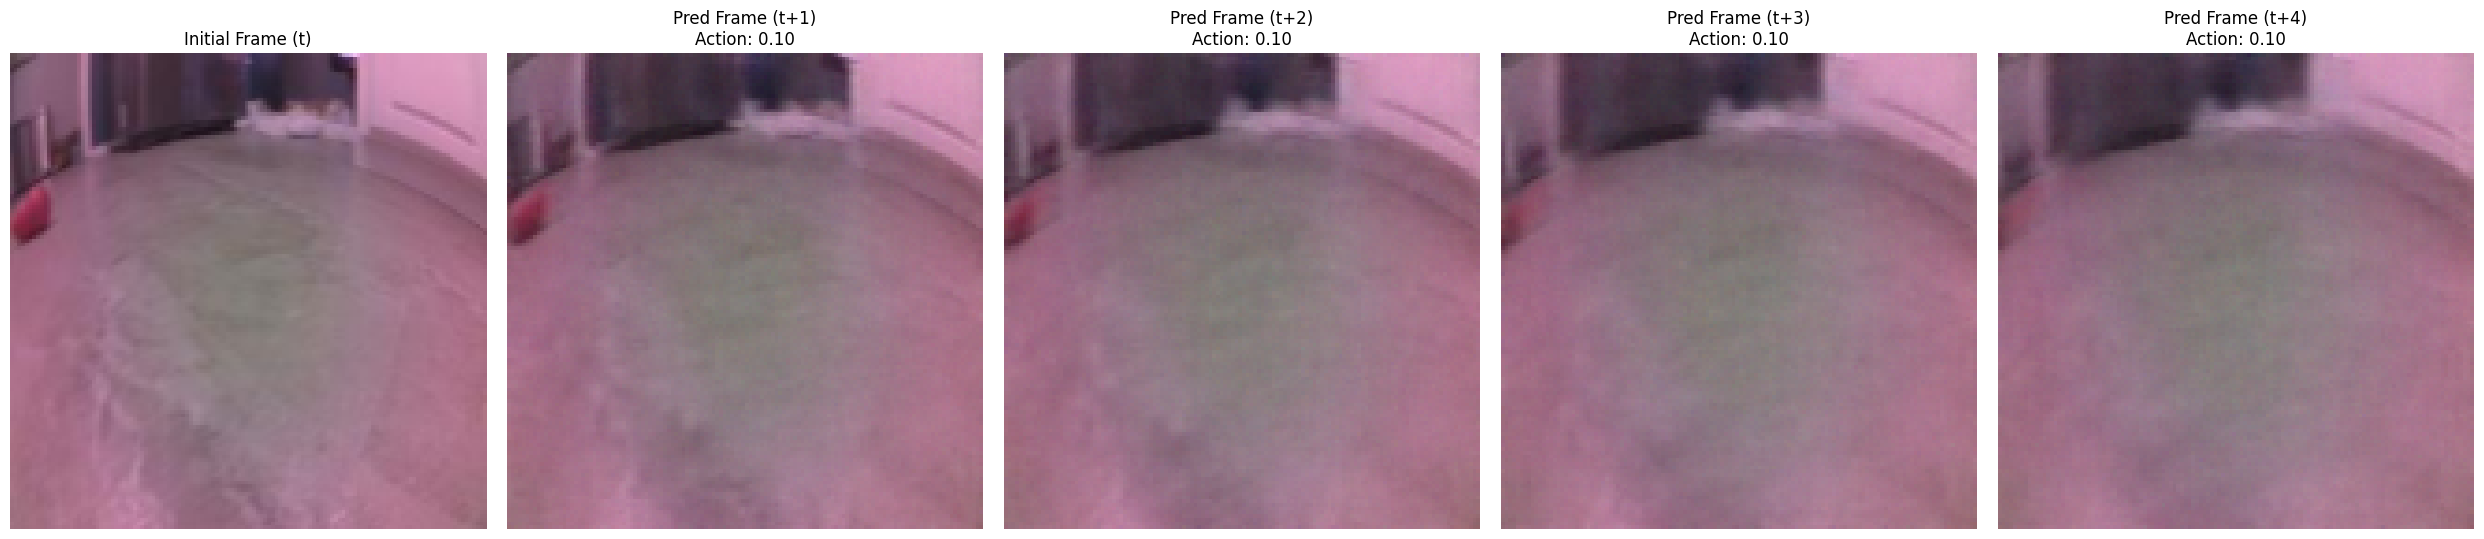

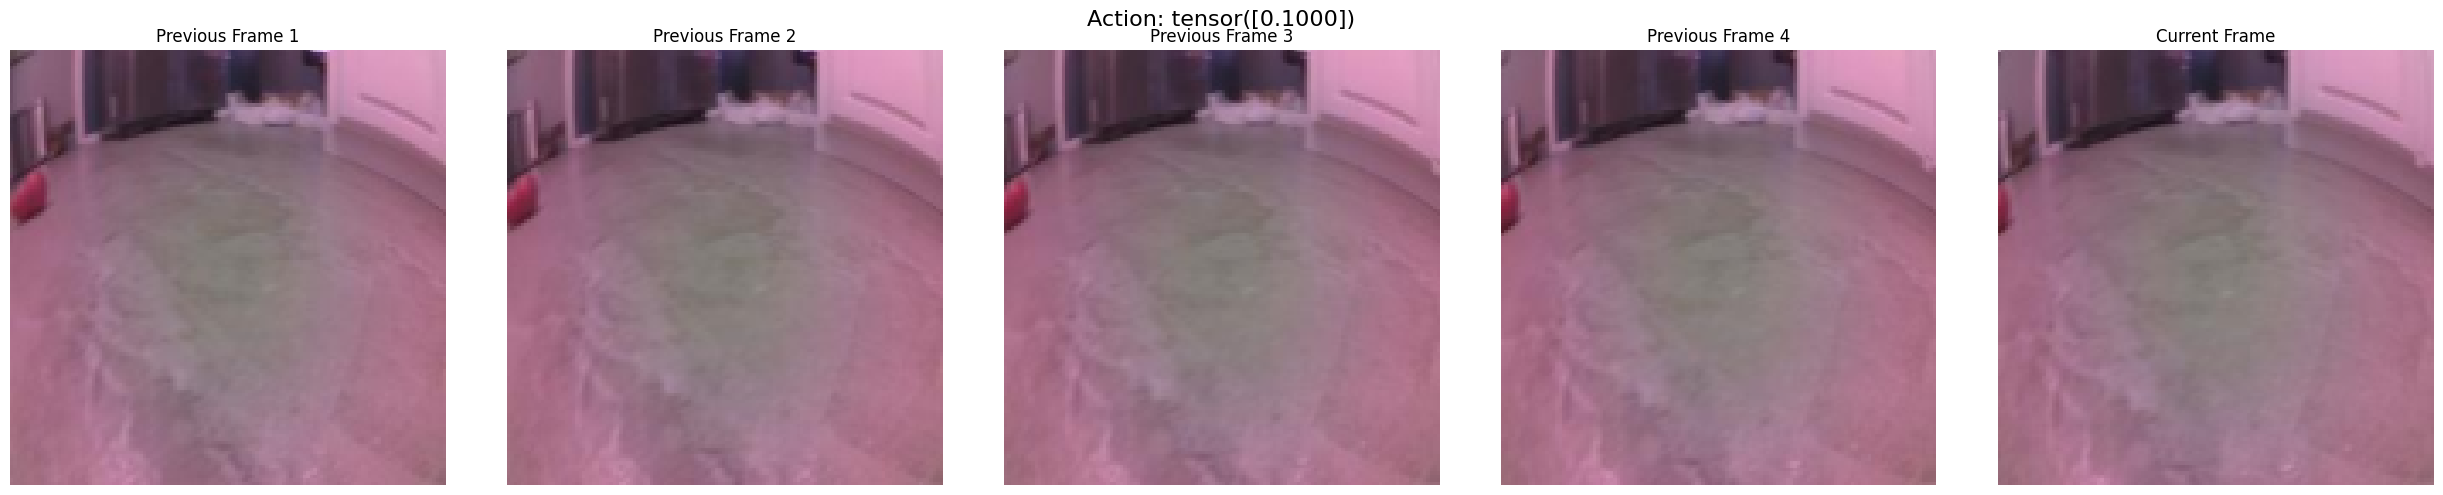

In [7]:
entry_indx = 2004
entry = dataset[entry_indx]
current_tensor, _, prev_frames_tensor = entry 


display_dataset_entry(entry)

# Create a sequence of actions
actions = torch.tensor([[0.1], [0.1], [0.1], [0.1]], dtype=torch.float32)

# Call the prediction function
predicted_frames = test_multistep_prediction(
            model,
            current_tensor.unsqueeze(0),  # Add batch dim for initial current tensor
            prev_frames_tensor.unsqueeze(0),# Add batch dim for initial prev tensor
            actions,                  # Future actions
            betas, alphas_cumprod,
            config.NUM_TIMESTEPS, config.DEVICE, config.NUM_PREV_FRAMES, config.IMAGE_SIZE,
            config.OUTPUT_DIR,
            display=True
        )

actual = dataset[entry_indx+config.NUM_PREV_FRAMES]
display_dataset_entry(actual)

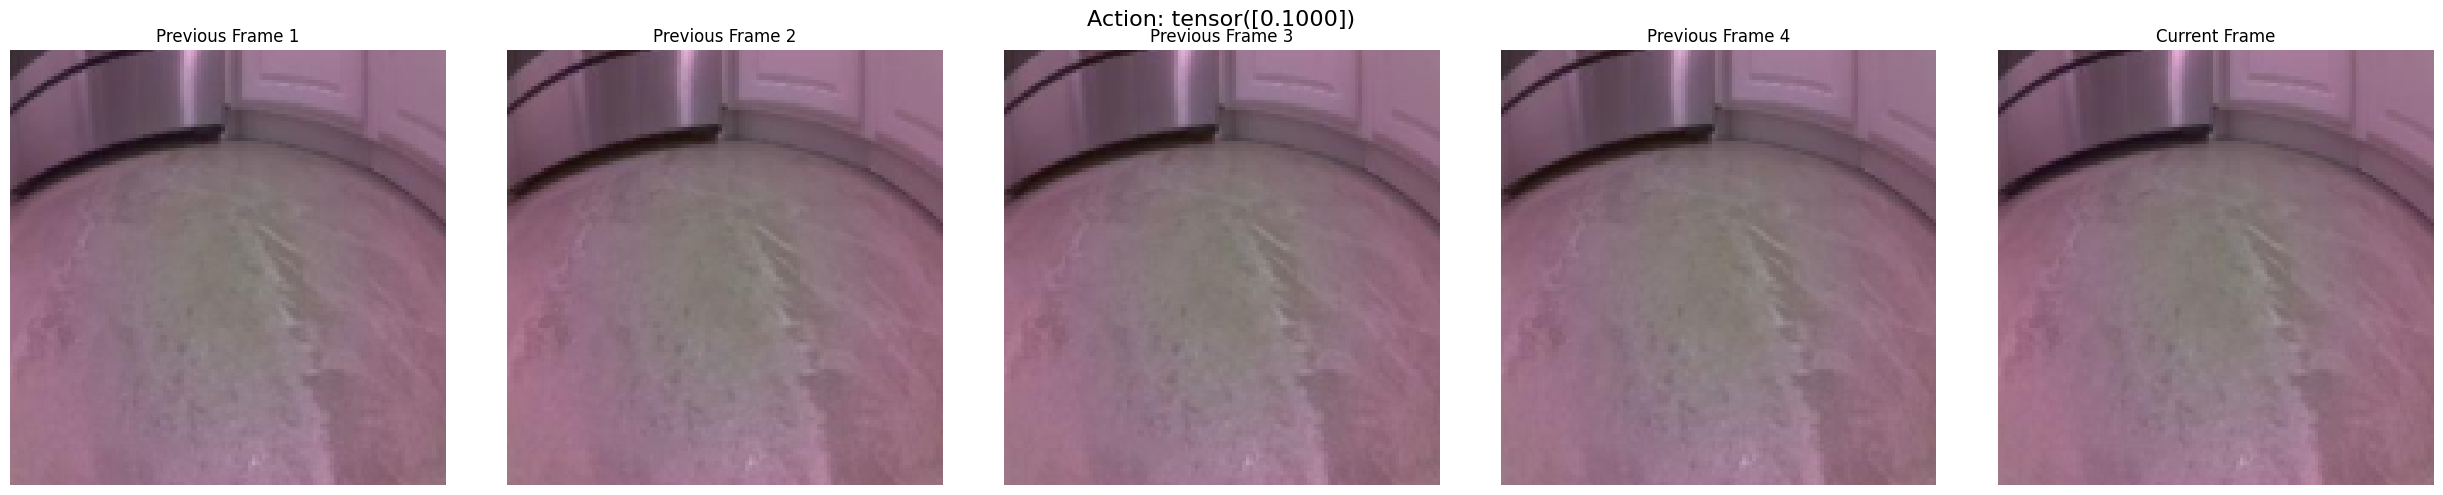

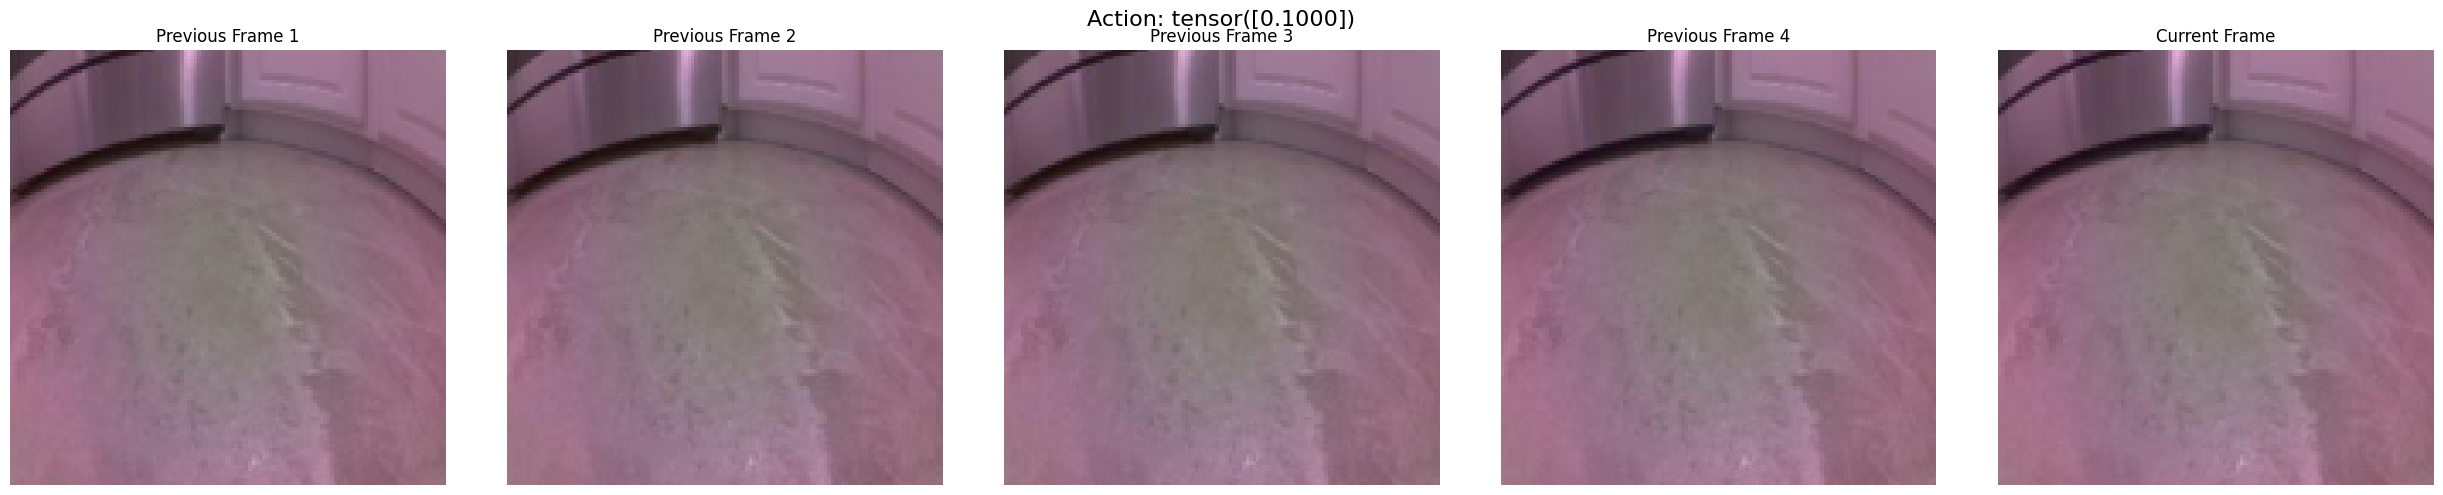

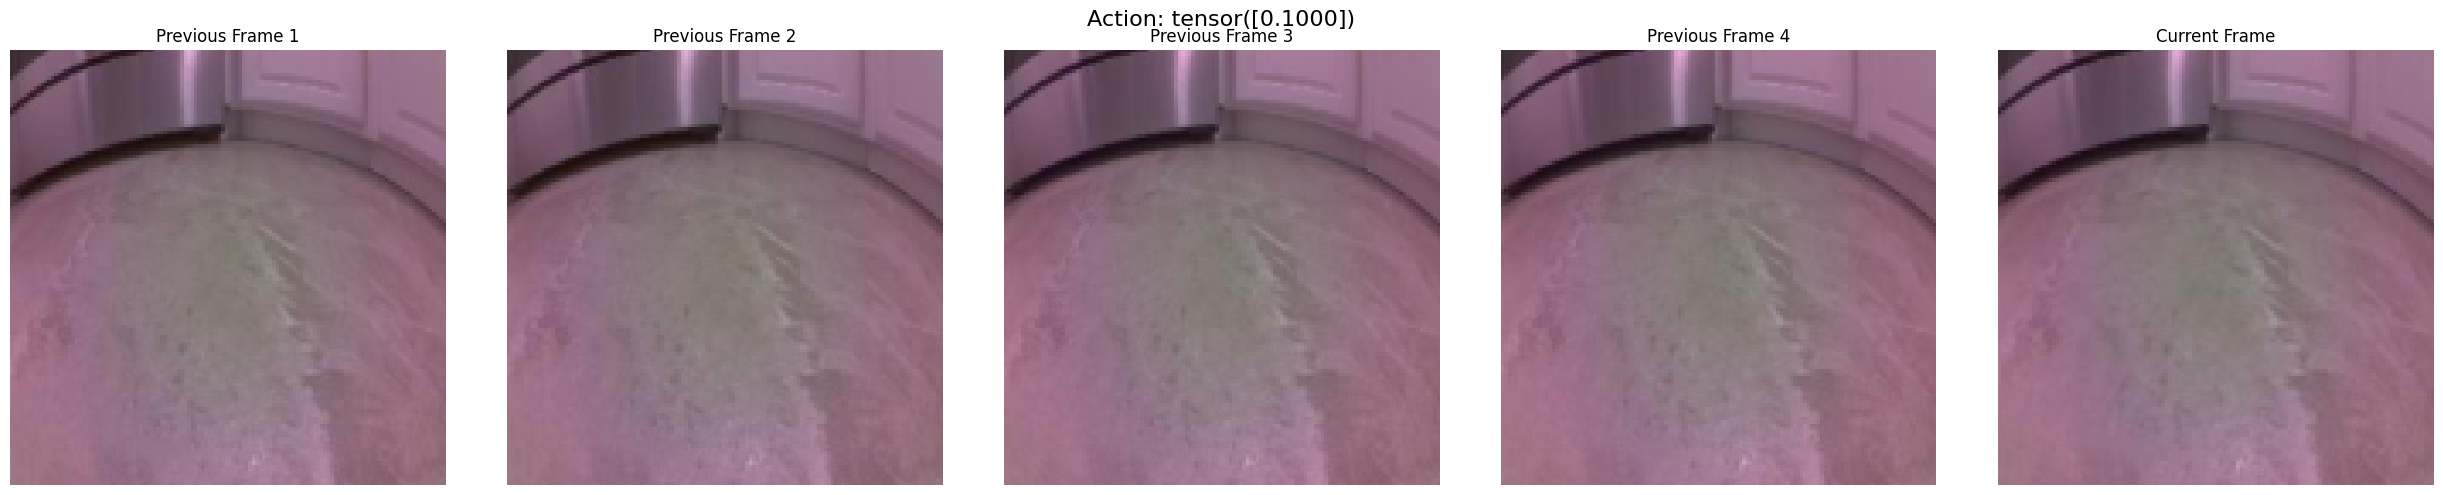

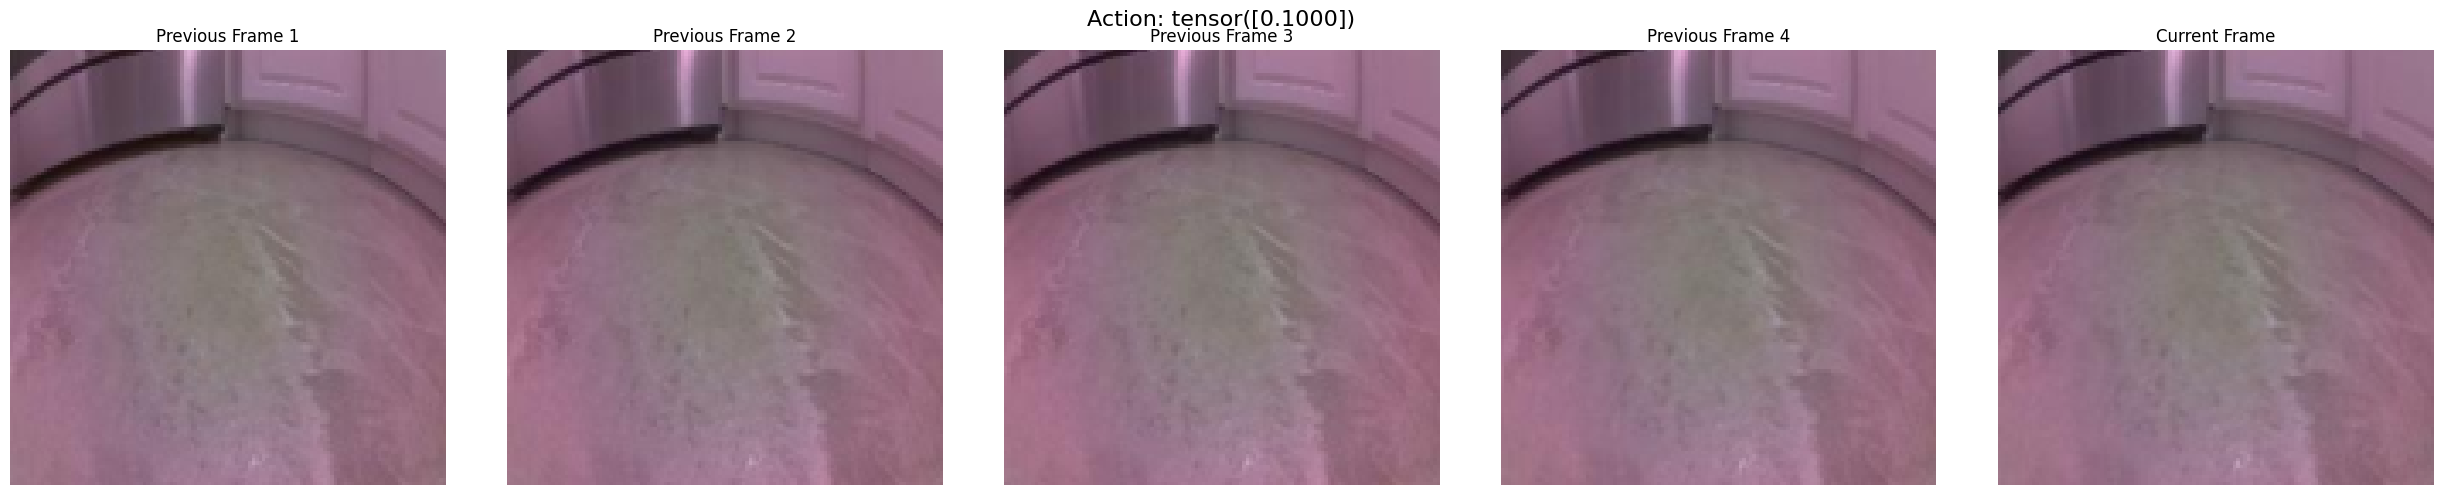

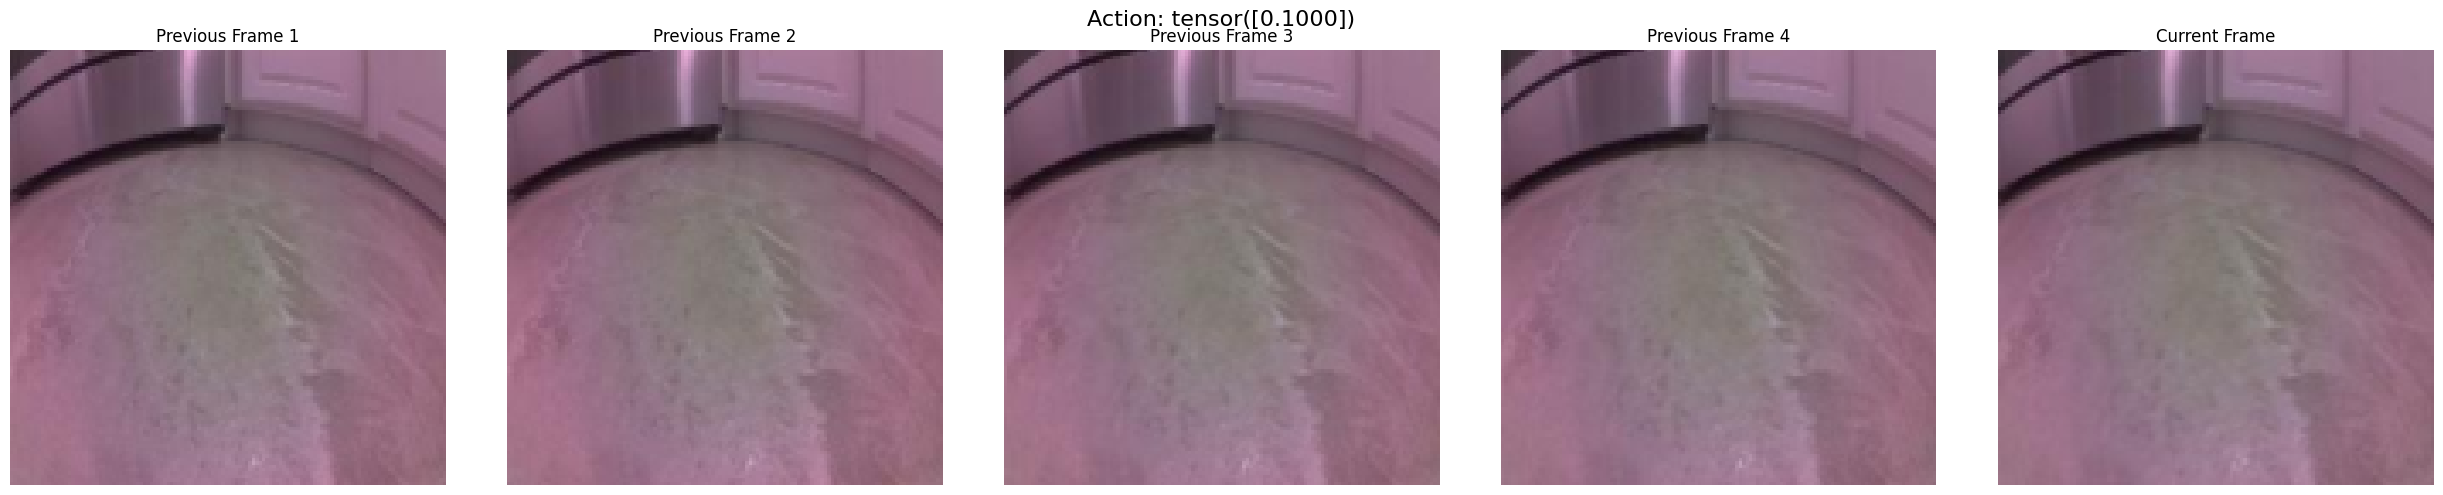

In [36]:
for i in range(5):
    entry = dataset_action_0_1[i]
    display_dataset_entry(entry)

In [15]:
dataset = JetbotDataset(config.IMAGE_DIR, config.CSV_PATH, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=config.TRANSFORM)
image, _, _ = dataset[25]

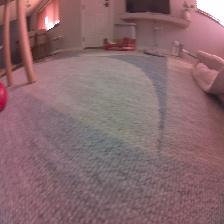

In [25]:
image
transforms.ToPILImage()(((image.clamp(-1, 1) + 1) / 2 * 255).type(torch.uint8)).convert("RGB")

In [9]:
image_clamped = (image.clamp(-1, 1) + 1) / 2
image_clamped

tensor([[[0.3804, 0.3843, 0.4039,  ..., 0.9961, 0.9961, 0.9961],
         [0.3804, 0.3686, 0.3804,  ..., 0.9961, 0.9961, 0.9961],
         [0.4196, 0.3922, 0.3804,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.5059, 0.4941, 0.4392,  ..., 0.4039, 0.4196, 0.3961],
         [0.4902, 0.4980, 0.4627,  ..., 0.3922, 0.4235, 0.4196],
         [0.4706, 0.5059, 0.4902,  ..., 0.3765, 0.4196, 0.4314]],

        [[0.2392, 0.2431, 0.2510,  ..., 0.9961, 0.9961, 0.9961],
         [0.2275, 0.2157, 0.2275,  ..., 0.9961, 0.9961, 0.9961],
         [0.2627, 0.2353, 0.2235,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.3961, 0.3843, 0.3294,  ..., 0.3059, 0.3216, 0.2980],
         [0.3804, 0.3882, 0.3529,  ..., 0.2941, 0.3255, 0.3216],
         [0.3608, 0.3961, 0.3804,  ..., 0.2784, 0.3216, 0.3333]],

        [[0.2471, 0.2510, 0.2549,  ..., 0.9961, 0.9961, 0.9961],
         [0.2392, 0.2196, 0.2314,  ..., 0.9961, 0.9961, 0.9961],
         [0.2667, 0.2392, 0.2275,  ..., 0.9961, 0.9961, 0.

In [10]:
image_255 = (image_clamped * 255).type(torch.uint8)
image_255

tensor([[[ 97,  98, 103,  ..., 254, 254, 254],
         [ 97,  94,  97,  ..., 254, 254, 254],
         [107, 100,  97,  ..., 254, 254, 254],
         ...,
         [129, 126, 112,  ..., 103, 107, 101],
         [125, 127, 118,  ..., 100, 108, 107],
         [120, 129, 125,  ...,  96, 107, 110]],

        [[ 60,  61,  64,  ..., 254, 254, 254],
         [ 57,  54,  57,  ..., 254, 254, 254],
         [ 67,  59,  56,  ..., 254, 254, 254],
         ...,
         [101,  98,  84,  ...,  78,  82,  76],
         [ 97,  99,  90,  ...,  75,  83,  82],
         [ 92, 101,  97,  ...,  71,  82,  85]],

        [[ 62,  64,  65,  ..., 254, 254, 254],
         [ 60,  55,  58,  ..., 254, 254, 254],
         [ 68,  60,  57,  ..., 254, 254, 254],
         ...,
         [116, 113,  98,  ...,  82,  86,  80],
         [112, 114, 104,  ...,  79,  87,  86],
         [107, 116, 111,  ...,  75,  86,  89]]], dtype=torch.uint8)

In [37]:
with torch.no_grad():
        # Outer loop: Predicts one future frame per iteration
        for step in range(num_steps):
            # 1. Get Action for this Step:
            #    - Selects the action from the input 'actions' tensor for the current future step.
            #    - Adds a batch dimension (unsqueeze(0)) because the model expects batch input.
            #    - Moves the action tensor to the correct device (CPU or GPU).
            action = actions[step].unsqueeze(0).to(device)

            # 2. Prepare for Denoising: Noise the *Current* State
            #    - t_sample represents the maximum noise level (T-1).
            t_sample = torch.tensor([num_timesteps - 1], device=device, dtype=torch.long)
            #    - forward_diffusion_sample takes the *current* frame tensor
            #      (which is either the initial frame for step 0, or the frame
            #      predicted in the previous step) and adds the maximum amount
            #      of noise to it, according to the diffusion schedule.
            #    - x_noisy is now a heavily noised version of current_frame_tensor.
            #      This serves as the starting point (x_T equivalent) for the
            #      reverse diffusion process to predict the *next* frame.
            x_noisy, _ = forward_diffusion_sample(current_frame_tensor, t_sample, betas, alphas_cumprod, device)
            #    - 'x' will be iteratively denoised in the inner loop.
            x = x_noisy

            # 3. Inner Loop: Reverse Diffusion (Denoising to Predict Next Frame)
            #    - Iterates backwards from the highest noise level (T-1) down to 1.
            for i in reversed(range(1, num_timesteps)):
                #    - 't' represents the current diffusion timestep in the reverse process.
                t = (torch.ones(1) * i).long().to(device)

                #    - Enable mixed precision (FP16) if configured, for potential speedup/memory saving.
                with torch.cuda.amp.autocast(enabled=config.USE_FP16):
                    #    - THE CORE PREDICTION: The U-Net model predicts the noise.
                    #      Inputs:
                    #        - x: The image at the current noise level 'i'.
                    #        - t: The current diffusion timestep 'i'.
                    #        - action: The specific action we want to condition this step's prediction on.
                    #        - prev_frames_tensor: The history of frames leading up to the 'current_frame_tensor'.
                    predicted_noise = model(x, t, action, prev_frames_tensor)

                #    - Retrieve pre-calculated diffusion schedule constants for timestep 't'.
                alpha = alphas[t][:, None, None, None]
                alpha_hat = alphas_cumprod[t][:, None, None, None]
                beta = betas[t][:, None, None, None]

                #    - Generate random noise (except for the very last step).
                #      This adds stochasticity to the generation process.
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x) # No noise added at the last step

                #    - Apply the denoising formula (DDPM/DDIM step):
                #      Uses the current noisy image 'x', the predicted_noise, and the
                #      schedule constants to estimate the image at the *previous*
                #      diffusion timestep (i-1). Updates 'x' in place for the next iteration.
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

            # --- End of Inner Denoising Loop ---
            # At this point, 'x' contains the denoised prediction for the frame
            # at the current outer 'step', still in the normalized range [-1, 1].

            # 4. Post-process the Predicted Frame:
            #    - Clamp values to [-1, 1], un-normalize to [0, 1].
            predicted_frame_tensor_unnorm = (x.clamp(-1, 1) + 1) / 2
            #    - Scale to [0, 255] and convert to uint8.
            predicted_frame_tensor_uint8 = (predicted_frame_tensor_unnorm * 255).type(torch.uint8)
            #    - Convert the single frame in the batch [0] to a PIL Image for storage/display.
            predicted_frame_pil = transforms.ToPILImage()(predicted_frame_tensor_uint8[0].cpu()).convert("RGB")
            #    - Add the predicted PIL image to the list.
            predicted_frames.append(predicted_frame_pil)

            # 5. Update State for the *Next* Prediction Step:
            #    - Convert the predicted PIL image back to a tensor [0, 1].
            current_frame_tensor_next_step = transforms.ToTensor()(predicted_frame_pil).unsqueeze(0)
            #    - Re-normalize the tensor back to [-1, 1] for the model input.
            current_frame_tensor_next_step = (current_frame_tensor_next_step - 0.5) / 0.5
            #    - Update 'current_frame_tensor' to be this newly predicted frame.
            current_frame_tensor = current_frame_tensor_next_step.to(device)
            #    - Update 'prev_frames_tensor' by removing the oldest frame in the stack
            #      and appending the newly predicted 'current_frame_tensor'.
            prev_frames_tensor = torch.cat([prev_frames_tensor[:, 3:, :, :], current_frame_tensor], dim=1)

        # --- End of Outer Prediction Loop ---
transforms.ToPILImage()(image_255).convert("RGB")

NameError: name 'image_255' is not defined